# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

  286720/11490434 [..............................] - ETA: 1s

 4661248/11490434 [===========>..................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:29 - loss: 0.6939

  31/1875 [..............................] - ETA: 3s - loss: 0.5423   

  61/1875 [..............................] - ETA: 3s - loss: 0.4640

  91/1875 [>.............................] - ETA: 3s - loss: 0.4226

 121/1875 [>.............................] - ETA: 2s - loss: 0.3956

 153/1875 [=>............................] - ETA: 2s - loss: 0.3748

 178/1875 [=>............................] - ETA: 2s - loss: 0.3620

 206/1875 [==>...........................] - ETA: 2s - loss: 0.3500

 232/1875 [==>...........................] - ETA: 2s - loss: 0.3404

 259/1875 [===>..........................] - ETA: 2s - loss: 0.3318

 290/1875 [===>..........................] - ETA: 2s - loss: 0.3231

 319/1875 [====>.........................] - ETA: 2s - loss: 0.3159

 345/1875 [====>.........................] - ETA: 2s - loss: 0.3101

 376/1875 [=====>........................] - ETA: 2s - loss: 0.3038

 402/1875 [=====>........................] - ETA: 2s - loss: 0.2989

 428/1875 [=====>........................] - ETA: 2s - loss: 0.2944

 450/1875 [======>.......................] - ETA: 2s - loss: 0.2909

 482/1875 [======>.......................] - ETA: 2s - loss: 0.2861

 509/1875 [=======>......................] - ETA: 2s - loss: 0.2823

 537/1875 [=======>......................] - ETA: 2s - loss: 0.2786

 567/1875 [========>.....................] - ETA: 2s - loss: 0.2749

 594/1875 [========>.....................] - ETA: 2s - loss: 0.2717

 621/1875 [========>.....................] - ETA: 2s - loss: 0.2687

 651/1875 [=========>....................] - ETA: 2s - loss: 0.2655

 678/1875 [=========>....................] - ETA: 2s - loss: 0.2629

 706/1875 [==========>...................] - ETA: 2s - loss: 0.2602

 733/1875 [==========>...................] - ETA: 2s - loss: 0.2577

 761/1875 [===========>..................] - ETA: 2s - loss: 0.2553

 789/1875 [===========>..................] - ETA: 1s - loss: 0.2530

 816/1875 [============>.................] - ETA: 1s - loss: 0.2508

 847/1875 [============>.................] - ETA: 1s - loss: 0.2484

 874/1875 [============>.................] - ETA: 1s - loss: 0.2464

 902/1875 [=============>................] - ETA: 1s - loss: 0.2445

 928/1875 [=============>................] - ETA: 1s - loss: 0.2427

 957/1875 [==============>...............] - ETA: 1s - loss: 0.2408

 988/1875 [==============>...............] - ETA: 1s - loss: 0.2388

1014/1875 [===============>..............] - ETA: 1s - loss: 0.2372

1037/1875 [===============>..............] - ETA: 1s - loss: 0.2359

1064/1875 [================>.............] - ETA: 1s - loss: 0.2343

1092/1875 [================>.............] - ETA: 1s - loss: 0.2327

1116/1875 [================>.............] - ETA: 1s - loss: 0.2314

1139/1875 [=================>............] - ETA: 1s - loss: 0.2302

1162/1875 [=================>............] - ETA: 1s - loss: 0.2290

1185/1875 [=================>............] - ETA: 1s - loss: 0.2279

1211/1875 [==================>...........] - ETA: 1s - loss: 0.2266

1238/1875 [==================>...........] - ETA: 1s - loss: 0.2253

1264/1875 [===================>..........] - ETA: 1s - loss: 0.2241

1291/1875 [===================>..........] - ETA: 1s - loss: 0.2229

1317/1875 [====================>.........] - ETA: 1s - loss: 0.2217

1344/1875 [====================>.........] - ETA: 0s - loss: 0.2205

1371/1875 [====================>.........] - ETA: 0s - loss: 0.2194

1398/1875 [=====================>........] - ETA: 0s - loss: 0.2183

1423/1875 [=====================>........] - ETA: 0s - loss: 0.2173

1450/1875 [======================>.......] - ETA: 0s - loss: 0.2162

1475/1875 [======================>.......] - ETA: 0s - loss: 0.2153

1501/1875 [=======================>......] - ETA: 0s - loss: 0.2143

1528/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1546/1875 [=======================>......] - ETA: 0s - loss: 0.2126

1566/1875 [========================>.....] - ETA: 0s - loss: 0.2119

1590/1875 [========================>.....] - ETA: 0s - loss: 0.2111

1616/1875 [========================>.....] - ETA: 0s - loss: 0.2102

1639/1875 [=========================>....] - ETA: 0s - loss: 0.2094

1663/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1691/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1718/1875 [==========================>...] - ETA: 0s - loss: 0.2069

1743/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1767/1875 [===========================>..] - ETA: 0s - loss: 0.2053

1790/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1811/1875 [===========================>..] - ETA: 0s - loss: 0.2040

1829/1875 [============================>.] - ETA: 0s - loss: 0.2035

1850/1875 [============================>.] - ETA: 0s - loss: 0.2029

1868/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2021


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1082

  21/1875 [..............................] - ETA: 4s - loss: 0.1101

  47/1875 [..............................] - ETA: 4s - loss: 0.1101

  73/1875 [>.............................] - ETA: 3s - loss: 0.1099

  97/1875 [>.............................] - ETA: 3s - loss: 0.1097

 124/1875 [>.............................] - ETA: 3s - loss: 0.1096

 149/1875 [=>............................] - ETA: 3s - loss: 0.1095

 174/1875 [=>............................] - ETA: 3s - loss: 0.1094

 200/1875 [==>...........................] - ETA: 3s - loss: 0.1093

 225/1875 [==>...........................] - ETA: 3s - loss: 0.1092

 250/1875 [===>..........................] - ETA: 3s - loss: 0.1091

 276/1875 [===>..........................] - ETA: 3s - loss: 0.1090

 303/1875 [===>..........................] - ETA: 3s - loss: 0.1089

 324/1875 [====>.........................] - ETA: 3s - loss: 0.1089

 351/1875 [====>.........................] - ETA: 3s - loss: 0.1088

 377/1875 [=====>........................] - ETA: 3s - loss: 0.1088

 403/1875 [=====>........................] - ETA: 2s - loss: 0.1087

 429/1875 [=====>........................] - ETA: 2s - loss: 0.1086

 455/1875 [======>.......................] - ETA: 2s - loss: 0.1086

 481/1875 [======>.......................] - ETA: 2s - loss: 0.1085

 508/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 535/1875 [=======>......................] - ETA: 2s - loss: 0.1084

 561/1875 [=======>......................] - ETA: 2s - loss: 0.1083

 588/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 613/1875 [========>.....................] - ETA: 2s - loss: 0.1082

 639/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 664/1875 [=========>....................] - ETA: 2s - loss: 0.1081

 690/1875 [==========>...................] - ETA: 2s - loss: 0.1081

 716/1875 [==========>...................] - ETA: 2s - loss: 0.1080

 742/1875 [==========>...................] - ETA: 2s - loss: 0.1080

 767/1875 [===========>..................] - ETA: 2s - loss: 0.1080

 794/1875 [===========>..................] - ETA: 2s - loss: 0.1079

 820/1875 [============>.................] - ETA: 2s - loss: 0.1079

 847/1875 [============>.................] - ETA: 2s - loss: 0.1078

 872/1875 [============>.................] - ETA: 1s - loss: 0.1078

 897/1875 [=============>................] - ETA: 1s - loss: 0.1077

 924/1875 [=============>................] - ETA: 1s - loss: 0.1077

 950/1875 [==============>...............] - ETA: 1s - loss: 0.1076

 976/1875 [==============>...............] - ETA: 1s - loss: 0.1076

1002/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1028/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1055/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1082/1875 [================>.............] - ETA: 1s - loss: 0.1074

1107/1875 [================>.............] - ETA: 1s - loss: 0.1073

1133/1875 [=================>............] - ETA: 1s - loss: 0.1073

1158/1875 [=================>............] - ETA: 1s - loss: 0.1072

1185/1875 [=================>............] - ETA: 1s - loss: 0.1072

1210/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1236/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1262/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1287/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1312/1875 [===================>..........] - ETA: 1s - loss: 0.1069

1336/1875 [====================>.........] - ETA: 1s - loss: 0.1069

1361/1875 [====================>.........] - ETA: 1s - loss: 0.1068

1387/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1413/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1439/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1464/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1489/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1515/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1542/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1569/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1594/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1619/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1645/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1670/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1696/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1721/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1747/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1773/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1799/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1824/1875 [============================>.] - ETA: 0s - loss: 0.1061

1850/1875 [============================>.] - ETA: 0s - loss: 0.1060

1875/1875 [==============================] - ETA: 0s - loss: 0.1060

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1060


Epoch 3/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0988

  27/1875 [..............................] - ETA: 3s - loss: 0.0995

  52/1875 [..............................] - ETA: 3s - loss: 0.0992

  77/1875 [>.............................] - ETA: 3s - loss: 0.0989

 102/1875 [>.............................] - ETA: 3s - loss: 0.0988

 128/1875 [=>............................] - ETA: 3s - loss: 0.0987

 154/1875 [=>............................] - ETA: 3s - loss: 0.0987

 180/1875 [=>............................] - ETA: 3s - loss: 0.0988

 205/1875 [==>...........................] - ETA: 3s - loss: 0.0988

 231/1875 [==>...........................] - ETA: 3s - loss: 0.0988

 256/1875 [===>..........................] - ETA: 3s - loss: 0.0987

 281/1875 [===>..........................] - ETA: 3s - loss: 0.0987

 307/1875 [===>..........................] - ETA: 3s - loss: 0.0987

 333/1875 [====>.........................] - ETA: 3s - loss: 0.0987

 359/1875 [====>.........................] - ETA: 3s - loss: 0.0987

 385/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0986

 437/1875 [=====>........................] - ETA: 2s - loss: 0.0986

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 488/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0985

 540/1875 [=======>......................] - ETA: 2s - loss: 0.0985

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 642/1875 [=========>....................] - ETA: 2s - loss: 0.0984

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0984

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0984

 708/1875 [==========>...................] - ETA: 2s - loss: 0.0984

 730/1875 [==========>...................] - ETA: 2s - loss: 0.0984

 754/1875 [===========>..................] - ETA: 2s - loss: 0.0984

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0983

 799/1875 [===========>..................] - ETA: 2s - loss: 0.0983

 816/1875 [============>.................] - ETA: 2s - loss: 0.0983

 840/1875 [============>.................] - ETA: 2s - loss: 0.0983

 867/1875 [============>.................] - ETA: 2s - loss: 0.0983

 894/1875 [=============>................] - ETA: 2s - loss: 0.0983

 919/1875 [=============>................] - ETA: 1s - loss: 0.0983

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1069/1875 [================>.............] - ETA: 1s - loss: 0.0982

1093/1875 [================>.............] - ETA: 1s - loss: 0.0982

1118/1875 [================>.............] - ETA: 1s - loss: 0.0982

1144/1875 [=================>............] - ETA: 1s - loss: 0.0982

1169/1875 [=================>............] - ETA: 1s - loss: 0.0981

1195/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1274/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1300/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1326/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1351/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0981

1404/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1430/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1481/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1583/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1835/1875 [============================>.] - ETA: 0s - loss: 0.0979

1861/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1036

  27/1875 [..............................] - ETA: 3s - loss: 0.0969

  52/1875 [..............................] - ETA: 3s - loss: 0.0963

  77/1875 [>.............................] - ETA: 3s - loss: 0.0962

 102/1875 [>.............................] - ETA: 3s - loss: 0.0961

 128/1875 [=>............................] - ETA: 3s - loss: 0.0961

 153/1875 [=>............................] - ETA: 3s - loss: 0.0961

 177/1875 [=>............................] - ETA: 3s - loss: 0.0961

 202/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 226/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 252/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 276/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 301/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 323/1875 [====>.........................] - ETA: 3s - loss: 0.0961

 347/1875 [====>.........................] - ETA: 3s - loss: 0.0961

 370/1875 [====>.........................] - ETA: 3s - loss: 0.0961

 390/1875 [=====>........................] - ETA: 3s - loss: 0.0961

 413/1875 [=====>........................] - ETA: 3s - loss: 0.0961

 436/1875 [=====>........................] - ETA: 3s - loss: 0.0961

 460/1875 [======>.......................] - ETA: 2s - loss: 0.0961



 483/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 528/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 699/1875 [==========>...................] - ETA: 2s - loss: 0.0961

 724/1875 [==========>...................] - ETA: 2s - loss: 0.0961

 750/1875 [===========>..................] - ETA: 2s - loss: 0.0961

 775/1875 [===========>..................] - ETA: 2s - loss: 0.0961

 800/1875 [===========>..................] - ETA: 2s - loss: 0.0961

 825/1875 [============>.................] - ETA: 2s - loss: 0.0961

 850/1875 [============>.................] - ETA: 2s - loss: 0.0961

 874/1875 [============>.................] - ETA: 2s - loss: 0.0961

 898/1875 [=============>................] - ETA: 2s - loss: 0.0961

 923/1875 [=============>................] - ETA: 2s - loss: 0.0961

 948/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1069/1875 [================>.............] - ETA: 1s - loss: 0.0961

1092/1875 [================>.............] - ETA: 1s - loss: 0.0961

1115/1875 [================>.............] - ETA: 1s - loss: 0.0961

1138/1875 [=================>............] - ETA: 1s - loss: 0.0961

1162/1875 [=================>............] - ETA: 1s - loss: 0.0961

1187/1875 [=================>............] - ETA: 1s - loss: 0.0961

1209/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1232/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1276/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0961

1337/1875 [====================>.........] - ETA: 1s - loss: 0.0961

1363/1875 [====================>.........] - ETA: 1s - loss: 0.0961

1382/1875 [=====================>........] - ETA: 1s - loss: 0.0961

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0961

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1458/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1817/1875 [============================>.] - ETA: 0s - loss: 0.0961

1842/1875 [============================>.] - ETA: 0s - loss: 0.0961

1868/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0946

  27/1875 [..............................] - ETA: 3s - loss: 0.0942

  52/1875 [..............................] - ETA: 3s - loss: 0.0946

  75/1875 [>.............................] - ETA: 3s - loss: 0.0948

  99/1875 [>.............................] - ETA: 3s - loss: 0.0949

 121/1875 [>.............................] - ETA: 3s - loss: 0.0950

 142/1875 [=>............................] - ETA: 3s - loss: 0.0951

 168/1875 [=>............................] - ETA: 3s - loss: 0.0952

 194/1875 [==>...........................] - ETA: 3s - loss: 0.0952

 219/1875 [==>...........................] - ETA: 3s - loss: 0.0953

 245/1875 [==>...........................] - ETA: 3s - loss: 0.0953

 271/1875 [===>..........................] - ETA: 3s - loss: 0.0953

 291/1875 [===>..........................] - ETA: 3s - loss: 0.0953

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0953

 338/1875 [====>.........................] - ETA: 3s - loss: 0.0953

 365/1875 [====>.........................] - ETA: 3s - loss: 0.0953

 387/1875 [=====>........................] - ETA: 3s - loss: 0.0953

 412/1875 [=====>........................] - ETA: 3s - loss: 0.0953

 433/1875 [=====>........................] - ETA: 3s - loss: 0.0954

 460/1875 [======>.......................] - ETA: 3s - loss: 0.0954

 482/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 500/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 663/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 713/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 738/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 764/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 789/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 814/1875 [============>.................] - ETA: 2s - loss: 0.0955

 839/1875 [============>.................] - ETA: 2s - loss: 0.0955

 865/1875 [============>.................] - ETA: 2s - loss: 0.0955

 890/1875 [=============>................] - ETA: 2s - loss: 0.0955

 915/1875 [=============>................] - ETA: 2s - loss: 0.0955

 940/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 963/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1022/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1067/1875 [================>.............] - ETA: 1s - loss: 0.0955

1091/1875 [================>.............] - ETA: 1s - loss: 0.0955

1113/1875 [================>.............] - ETA: 1s - loss: 0.0955

1139/1875 [=================>............] - ETA: 1s - loss: 0.0955

1166/1875 [=================>............] - ETA: 1s - loss: 0.0955

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1268/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1294/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1343/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1395/1875 [=====================>........] - ETA: 1s - loss: 0.0955

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1446/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1548/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1834/1875 [============================>.] - ETA: 0s - loss: 0.0954

1861/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

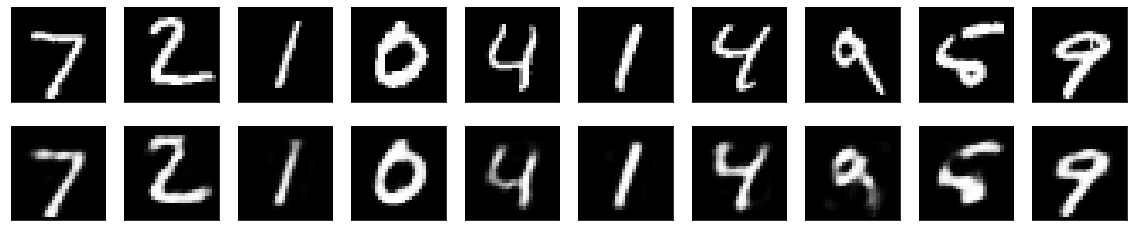

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
